# Building Seasons for North Carolina
### Unsupervised Learning with k-Means Clustering

In this notebook, I implement my own version of k-means clustering, compare it to the `sklearn` implementations of k-means and spectral clustering, then use my implementation to determine that North Carolina's weather is best described in __ seasons.

In [155]:
import pandas as pd
import numpy as np

# ML tools
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering 
from scipy.spatial import distance

# plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import calendar

# benchmarking
import timeit
import time

In [156]:
# helper functions

# adapted from original code in lab 6
def standardize(data):
    '''standardize each column of a numpy dataframe'''
    mean_vec = np.mean(data, axis=0)
    sd_vec = np.std(data, axis=0)

    data_std = data.copy()
    for i in range(data.shape[1]): # for every column
        data_std[:,i] = (data[:,i] - mean_vec[i]*np.ones(data.shape[0]))/sd_vec[i]
        
    return data_std

## Import Data
We are once again exploring weather data for the RDU airport in NC's Research Triangle region, as explored in `data/Data-Wrangling.ipynb` and `data/Data-Visualization.ipynb`.

In [157]:
# import data
weather_pd = pd.read_csv('../data/weather.csv', index_col = 0)

In [158]:
# peek at data
weather_pd.head()

,YEAR,MONTH,DAY,SEASON,TEMP,DEWP,SLP,STP,VISIB,WDSP,MXSPD,GUST,MAX,MIN,PRCP,SNDP
0,2000,1,1,0,47.6,38.1,1023.7,999.9,8.3,3.0,10.1,0.0,66.9,33.1,0.00,0.0
1,2000,1,2,0,55.3,46.3,1024.2,999.9,9.5,4.8,14.0,0.0,70.0,33.1,0.00,0.0
2,2000,1,3,0,62.6,55.4,1021.3,999.9,8.4,8.5,14.0,0.0,73.9,43.0,0.00,0.0
3,2000,1,4,0,65.2,58.6,1014.4,999.9,9.5,15.3,28.0,35.9,73.9,55.0,0.00,0.0
4,2000,1,5,0,45.7,30.9,1019.8,999.9,9.8,6.4,11.1,18.1,57.9,37.0,0.34,0.0


When we convert the data to `numpy` and standardize it, we also drop variables that are missing for large portions of the data (`STP` and `GUST`) or likely irrelevant to the data (`YEAR` and `DAY`).

In [159]:
# convert to numpy
weather = weather_pd.drop(['YEAR', 'DAY', 'STP', 'GUST'], axis=1).to_numpy()
# standardize data
weather_std = standardize(weather)

# print shape
weather_std.shape

(7772, 12)

## Glimpse Data in 2d
Our weather data contains 12 variables including information on temperatures, pressure, visibility, wind speed, precipitation, and more. We can summarize this data in 2D to get a sense of the general shape of the data. Below, we label our data by season and observe four fairly distinct regions of weather, but no clear separation between seasons. This lack of clear boundaries is to be expected, since seasons don't change overnight—some days will fall in the transition between seasons. There are also a few days where the weather clearly deviates far from normal, especially in the winter (purple).

In [160]:
# summarize in 2D
pca = PCA(n_components=2)
weather_two = pca.fit_transform(weather_std)

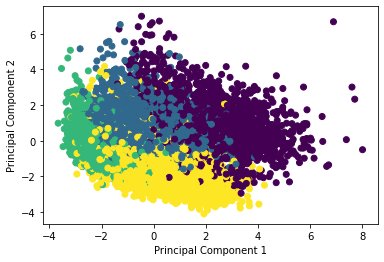

In [161]:
# plot 2D weather with colors by cluster
# winter = purple, spring = blue, summer = green, fall = yellow
plt.scatter(weather_two[:,0], weather_two[:,1], c=weather_pd['SEASON'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2');

## Implementing k-Means from Scratch
I start with building my own k-means algorithm for finding weather clusters in this data. This k-means implementation follows the classic k-means algorithm: starting with *k* random cluster centers, assign each datapoint to the nearest cluster center, recalculate the cluster centers as the average of all datapoints in that cluster, and repeat until cluster assignments stabilize or a maxiumum number of iterations is reached.

In [162]:
# adapted from original code in Homework 2
def my_kmeans(data, k):
    '''returns labels for k clusters in the data (np array)'''
    # set random start state
    r_state = 101
    
    # start with two random centers
    data_pd = pd.DataFrame(data)
    centers = data_pd.sample(k, random_state = r_state).to_numpy()
    
    verbose = False
    if verbose:
        print(centers)
    
    # one possible stop condition
    maxIter = 300
    
    # each iteration
    for it in range(maxIter):
        if verbose:
            print(it)
        # find distance from center of each cluster
        dists = distance.cdist(data, centers, 'euclidean')

        # assign to cluster
        clusters = np.argmin(dists, axis=1)

        # update centers
        new_centers = np.zeros((k, data.shape[1])) # initialize new centers array
        # for each cluster
        for i in range(len(centers)):
            # take points in cluster
            cluster = data[clusters == i]
            # their avg is new center of cluster
            new_centers[i] = np.mean(cluster, axis = 0)
            
        # print updated centers
        if verbose:
            print(new_centers)

        # stop condition
        if (new_centers == centers).all(): # we didn't change centers
            if verbose:
                print("didn't change centers")
            break
        else:
            centers = new_centers # update centers and continue
            
    # return cluster assignments
    return clusters, centers

In [163]:
# run my k-means for 4 seasons
labels, centers = my_kmeans(weather_std, 4)

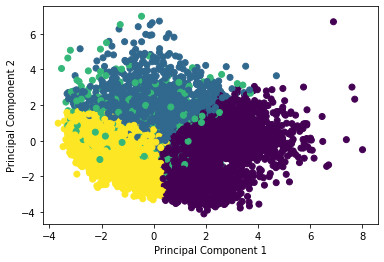

In [164]:
# plot 2D weather with colors by cluster
plt.scatter(weather_two[:,0], weather_two[:,1], c=labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2');

Even though I specified four clusters, my algorithm found three regions of weather, with two clusters overlapping. This could potentially indicate that our weather belongs in fewer than four seasons. 

## Comparison to `sklearn` Implementation

Before we launch into determining the optimal number of weather clusters for NC, let's explore how our implementation compares to the "off the shelf" `sklearn` implementation of k-means.

In [165]:
# functions for calling sklearn's kmeans/spectral clustering in same format as my_kmeans
# adapted from original code in Homework 3
def kmeans_sklearn(data, k):
    '''returns labels for k clusters in the data'''
    km_alg = KMeans(n_clusters=k)
    fit1 = km_alg.fit(data)
    labels = fit1.labels_
    centers = fit1.cluster_centers_
    return labels, centers

In [166]:
%%timeit
# time my implementation of k-means clustering
labels4, centers = my_kmeans(weather_std, 4)
labels8, centers = my_kmeans(weather_std, 8)
labels12, centers = my_kmeans(weather_std, 12)

117 ms ± 4.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [167]:
%%timeit
# time sklearn implementation of k-means clustering
labels_kmeans_4, centers = kmeans_sklearn(weather_std, 4)
labels_kmeans_8, centers = kmeans_sklearn(weather_std, 8)
labels_kmeans_12, centers = kmeans_sklearn(weather_std, 12)

798 ms ± 28.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


After timing my k-means implementation and the `sklearn` implementation on a variety of cluster sizes, we find that my k-means immplementation runs most efficiently, at a rate of about 117 ms for three calls. The `sklearn` version of k-means is similarly fast, but is likely slowed down by the overhead of all the optional parameters and extra features that make the `sklearn` implementation more versatile. Once we fit the `sklearn` k-means algorithm to the data, we can use that algorithm to predict clusters of new datapoints or return more information about the clusters, while my implementation is built only to return cluster labels and centers. The `sklearn` implementation could also be optimized for much larger datasets; it would be interesting to compare my implementation with the `sklearn` implementation on a dataset with millions of datapoints.

In [170]:
# load the line_profiler extension
%load_ext line_profiler

In [172]:
# line by line profiling my_kmeans
%lprun -f my_kmeans my_kmeans(weather_std, 4)

Computational complexity - each iteration is an epoch (runs over whole dataset)

In [ ]:
# load the memory_profiler extension
%load_ext memory_profiler

In [ ]:
%memit my_kmeans(weather_std, 4)

In [ ]:
%mprun -f my_kmeans my_kmeans(weather_std, 4)

## Comparison to Spectral Clustering

Out of curiosity, let's also test how spectral clustering performs on the dataset. Spectral clustering combines dimension reduction and k-means to detect clusters that don't fall into a nice circular shape, so it's usually a more versatile clustering algorithm than k-means, but I would expect it to perform poorly on this nicely round data.

In [ ]:
# adapted from original code in Homework 3
def spectral_sklearn(data, k):
    '''returns labels for k clusters in the data'''
    sc_alg = SpectralClustering(n_clusters=k)
    fit1 = sc_alg.fit(data)
    labels = fit1.labels_
    centers = fit1.cluster_centers_
    return labels, centers

This will take a moment to run:

In [ ]:
%%time
# time sklearn implementation of spectral clustering
labels_spect, centers = spectral_sklearn(weather_std, 4)

We find that spectral clustering takes much longer to converge and converges on fewer than four clusters. In fact, if we plot the labels on the datapoints, we find that spectral clustering made no attempt to subdivide our large blob of weather:

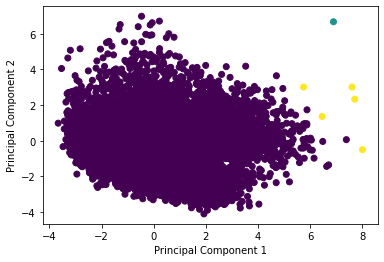

In [175]:
# plot 2D weather with colors by spectral clustering assignment
plt.scatter(weather_two[:,0], weather_two[:,1], c=labels_spect)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2');

Overall, spectral clustering is a very poor fit for this clustering task, despite usually being more versatile than k-means.

## Finding the Optimal Number of Seasons

Now that we have built k-means clustering from scratch and compared this implementation to "off the shelf" `sklearn` clustering algorithms, let's use my implementation to explore the optimal number of clusters for North Carolina's seasons. We can visually guesstimate the best number of clusters for the data by plotting cluster "goodness" vs. number of clusters and finding the most dramatic change in slope in the plot—where adding more clusters stops being so useful for getting points closer to the cluster centers. We'll use within cluster sum of squares as a measure of cluster "goodness," which computes how far the datapoints are from their cluster centers.

In [104]:
# adapted from original code in Homework 2
def looping_kmeans(data, kList):
    '''find within cluster sum of squares of k-means for k-values in kList'''
    goodnessList = []
    
    # for each k
    for k in kList:
        # fit k-means for k clusters
        labels, centers = my_kmeans(data, k)
        
        # initialize within cluster sum of squares
        within_cluster_sumsqs = 0

        # loop over clusters
        for c in range(len(centers)):
            # cluster's center and associated points
            cluster_center = [centers[c, :]]
            cluster_points = data[labels == c]

            # distance of each point from the center
            cluster_spread = distance.cdist(cluster_points, cluster_center, 'euclidean')
            
            # total distance of all points from the center (in this cluster)
            cluster_total = np.sum(cluster_spread)

            # add this cluster's within sum of squares to total within_cluster_sumsqs
            within_cluster_sumsqs = within_cluster_sumsqs + cluster_total

        # store goodness for this k
        goodnessList.append(within_cluster_sumsqs)
    
    # goodness for each k
    return goodnessList

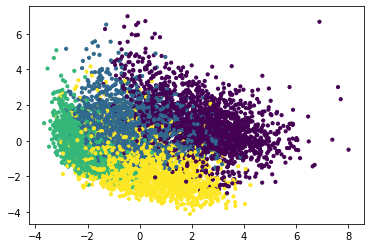

In [131]:
# test k in [2,12]
kList = [x for x in range(2, 13)]
gList = looping_kmeans(weather_std, kList)

In [ ]:
# plot goodness vs. values of k
plt.plot(kList, gList, '-o')

We observe that

In [ ]:
# run k-means for _ clusters
labels, centers = my_kmeans(weather_std, 12)

In [ ]:
# plot 2D weather with colors by cluster
plt.scatter(weather_two[:,0], weather_two[:,1], c=labels_spect)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2');

# plot alongside old seasons?

## A New Seasonal Calendar

If NC's weather falls into _ seasons, when are they? Let's plot a calendar of the seasons for 2019 and 2020.

In [107]:
# calendar plotting functions
# adapted from https://dzone.com/articles/plotting-a-calendar-in-matplotlib
def plot_calendar(days, months, colors, year):
    '''Build a calendar for {year} given lists for day, month, and color for each day'''
    plt.figure(figsize=(9, 3))
    # colors from https://mycolor.space/
    COLORS = ['#845EC2', '#D65DB1', '#FF6F91', '#FF9671', '#FFC75F', '#F9F871',
              '#9BDE7E', '#4BBC8E', '#039590', '#1C6E7D', '#2F4858', '#676A8B'] # 12 colors for now
    ax = plt.gca().axes
    # plot days
    for d, m, c in zip(days, months, colors):
        ax.add_patch(Rectangle((d, m), 
                               width=.8, height=.8, color=COLORS[c]))
    plt.yticks(np.arange(1, 13)+.5, list(calendar.month_abbr)[1:])
    plt.xticks(np.arange(1,32)+.5, np.arange(1,32))
    plt.xlim(1, 32)
    plt.ylim(1, 13)
    plt.title('The {} Seasons of {}'.format(len(np.unique(colors)), year))
    plt.gca().invert_yaxis()
    # remove borders and ticks
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.tick_params(top=False, bottom=False, left=False, right=False)
    plt.show()
    
def plot_labels(weather_pd, labels, year):
    '''For a particular year, color the calendar with season labels'''
    # add new season labels to data
    weather_pd['NEW_SEASON'] = labels
    # filter data for year
    weather_year = weather_pd[weather_pd['YEAR'] == year]
    # plot this year's calendar
    plot_calendar(weather_pd['DAY'], weather_pd['MONTH'], weather_pd['NEW_SEASON'], year)

In [ ]:
# plot 2019
plot_labels(weather_pd, labels_kmeans, 2019)

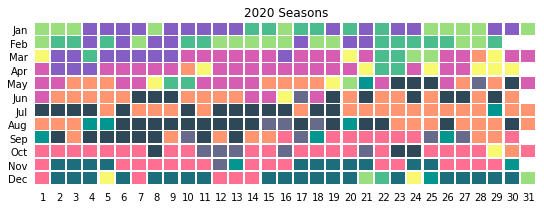

In [130]:
# plot 2020
plot_labels(weather_pd, labels_kmeans, 2020)

## Conclusion

assess calendar